In [1]:
import os
from collections import defaultdict
import matplotlib.pyplot as plt
import mdtraj
import numpy as np

import alphaspace2 as al
import alphaspace2.Features as features  ## python module with pseudomolecular features

This tutorial shows how to apply pocket features to compare the pocket/ligand similarities, here we selected 10 HIV-protease
inhibitors from our database

In [2]:
protease_list = ['1c70','1hvi','1hvj','1izh','1pro','1siv','2i0a','2psv','2q5k','3lzu']

calculating pockets for pro teases, pka, and estrogen receptor

In [3]:
this_dir = os.path.abspath('')

protease_data_lig = {}
protease_data_ss = {}
protease_data_prot = {}
for pdb_id in protease_list:
    prot = mdtraj.load(this_dir+'/DataSet/Beta_Cluster_features/protein_' + pdb_id + '.pdb')
    protease_data_prot[pdb_id] = prot
    lig = mdtraj.load(this_dir+'/DataSet/Beta_Cluster_features/ligand_' + pdb_id + '.pdb')
    protease_data_lig[pdb_id] = lig
    ss_prot = al.Snapshot()
    ss_prot.run(prot, lig)
    protease_data_ss[pdb_id] = ss_prot

use usr features as an example


In [4]:
protease_contact_pockets = defaultdict(dict)
for pdb_id in protease_data_ss:
    for px,pocket in enumerate(protease_data_ss[pdb_id].pockets):
        if pocket.isContact:
            protease_contact_pockets[pdb_id][px] = np.array([b.xyz for b in pocket.betas])

Calculate Occluded ASA, USR, Normalized PMI, span and radius of gyration by calling the followinbg functions

In [5]:
protease_pocket_props_dict = {}
for pdb_id in protease_contact_pockets:
    contact_betas = []
    prot = protease_data_prot[pdb_id]
    for px in protease_contact_pockets[pdb_id]:
        contact_betas.extend(protease_contact_pockets[pdb_id][px])
    contact_betas = np.array(contact_betas)  
    protease_pocket_props_dict[pdb_id] = {
        'occluded_asa' : features._get_pharmacophore_fingerprint(prot,contact_betas),
        'usr' : features._Get_USR_alpha_beta(contact_betas),
        'normalized_PMI' : features._calculate_NormalizedRatioPMI(contact_betas),
        'span' : features._calculate_SPAN(contact_betas),
        'radius_of_gyration' : features._calculate_RadiusofGyration(contact_betas), 
        
    }     

In [6]:
### repeat calculation for ligands ###
protease_ligand_props_dict = {}
for pdb_id in protease_data_prot:
    lig = protease_data_lig[pdb_id]
    prot = protease_data_prot[pdb_id]
    lig_coords = lig.xyz[0]*10   ### multiply by 10 to convert nm to Angstrom  
    protease_ligand_props_dict[pdb_id] = {
        'occluded_asa': features._get_pharmacophore_fingerprint(prot,lig_coords),
        'usr': features._Get_USR_alpha_beta(lig_coords),
        'normalized_PMI': features._calculate_NormalizedRatioPMI(lig_coords),
        'span':features._calculate_SPAN(lig_coords),
        'radius_of_gyration': features._calculate_RadiusofGyration(lig_coords)  
        
    }         

PDB_ID   PocketSpan      LigandSpan
1c70 	 9.836   	 7.644
1hvi 	 12.357   	 9.667
1hvj 	 12.107   	 9.898
1izh 	 10.926   	 8.833
1pro 	 11.557   	 7.44
1siv 	 10.41   	 10.339
2i0a 	 10.949   	 10.784
2psv 	 10.012   	 8.257
2q5k 	 12.12   	 8.934
3lzu 	 8.951   	 8.506


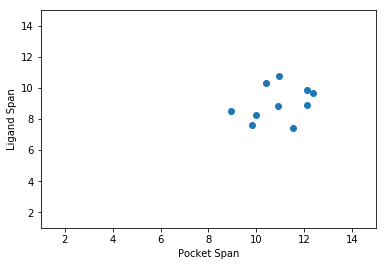

In [17]:
### can compare different features ###

print("PDB_ID   PocketSpan      LigandSpan")
for pdb_id in protease_list:
    print(pdb_id, '\t' , round(protease_pocket_props_dict[pdb_id]['span'],3),'  \t', round(protease_ligand_props_dict[pdb_id]['span'],3))
    
pocket_span = [protease_pocket_props_dict[pdb_id]['span'] for pdb_id in protease_list]
ligand_span = [protease_ligand_props_dict[pdb_id]['span'] for pdb_id in protease_list]

plt.scatter(pocket_span,ligand_span,)
plt.xlabel('Pocket Span')
plt.ylabel('Ligand Span')
plt.xlim(1,15)
plt.ylim(1,15)
plt.show()
    
    

PDB_ID   PocketRoG      LigandRoG
1c70 39.58 37.095
1hvi 59.994 46.608
1hvj 57.402 46.324
1izh 50.292 40.43
1pro 38.271 31.486
1siv 44.089 38.497
2i0a 44.869 38.951
2psv 36.763 25.815
2q5k 50.799 36.354
3lzu 35.415 29.268


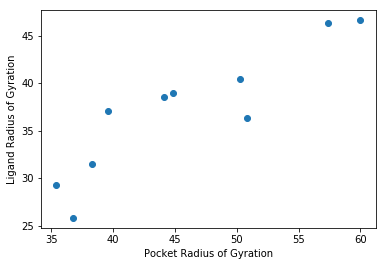

In [18]:
print("PDB_ID   PocketRoG      LigandRoG")
for pdb_id in protease_list:
    print(pdb_id, round(protease_pocket_props_dict[pdb_id]['radius_of_gyration'],3), round(protease_ligand_props_dict[pdb_id]['radius_of_gyration'],3))
pocket_rog = [protease_pocket_props_dict[pdb_id]['radius_of_gyration'] for pdb_id in protease_list]
ligand_rog = [protease_ligand_props_dict[pdb_id]['radius_of_gyration'] for pdb_id in protease_list]

plt.scatter(pocket_rog,ligand_rog,)
plt.xlabel('Pocket Radius of Gyration')
plt.ylabel('Ligand Radius of Gyration')
plt.show()
    


In [19]:
### get similarity of occluded surface area and USR features ###
print("PDB_ID   OASA_Sim   USR_Sim")
for pdb_id in protease_list:
    oasa_pocket = [s for _,s in protease_pocket_props_dict[pdb_id]['occluded_asa'].items()]
    oasa_ligand = [s for _,s in protease_ligand_props_dict[pdb_id]['occluded_asa'].items()]
    oasa_similarity = 1 - features._soergel(oasa_pocket,oasa_ligand)
    usr_similarity = 1 - features._soergel(protease_pocket_props_dict[pdb_id]['usr'],protease_ligand_props_dict[pdb_id]['usr'])
    print(pdb_id, round(oasa_similarity,3),round(usr_similarity,3))



PDB_ID   OASA_Sim   USR_Sim
1c70 0.909 0.816
1hvi 0.767 0.804
1hvj 0.822 0.866
1izh 0.802 0.795
1pro 0.892 0.771
1siv 0.815 0.891
2i0a 0.76 0.922
2psv 0.86 0.761
2q5k 0.741 0.796
3lzu 0.804 0.832
